### Import PyTorch

In [1]:
import torch
from torch import nn

print(torch.__version__)

2.7.1+cu128


### Check CUDA enabled

In [2]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))

Torch version: 2.7.1+cu128
CUDA available: True
CUDA version: 12.8
Device count: 1
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU


### Create Data

In [25]:
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=42)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split data into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=42)

X_blob_train, y_blob_train

(tensor([[ 5.0405,  3.3076],
         [-2.6249,  9.5260],
         [-8.5240, -9.0402],
         ...,
         [-1.7366,  9.7850],
         [-6.8139, -7.1006],
         [-9.0311,  4.5007]]),
 tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0, 0, 0, 3, 2, 3, 2, 1, 1, 3, 2, 2, 2, 3, 1,
         3, 2, 3, 0, 1, 0, 0, 1, 1, 3, 0, 2, 2, 1, 1, 3, 1, 1, 2, 3, 3, 0, 0, 0,
         1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 2, 2, 3, 1, 0, 2, 1, 3, 2, 2, 2, 1, 0, 2,
         3, 1, 1, 1, 2, 0, 0, 1, 2, 3, 1, 3, 3, 2, 3, 3, 2, 2, 1, 0, 0, 1, 2, 1,
         3, 1, 2, 1, 3, 3, 3, 0, 2, 1, 2, 3, 1, 1, 2, 0, 3, 3, 2, 0, 2, 0, 3, 2,
         0, 0, 2, 2, 0, 1, 2, 0, 3, 3, 2, 3, 2, 1, 3, 1, 1, 1, 1, 0, 0, 1, 0, 2,
         3, 0, 0, 0, 0, 0, 1, 0, 3, 0, 0, 2, 2, 0, 0, 3, 0, 3, 3, 3, 0, 2, 0, 1,
         2, 2, 2, 3, 0, 1, 1, 0, 1, 2, 0, 3, 2, 1, 3, 2, 3, 0, 3, 1, 1, 2, 2, 2,
         2, 2, 2, 0, 3, 3, 2, 1, 1, 2, 3, 1, 0, 0, 1, 3, 0, 1, 3, 3, 2, 3, 3, 3,
         1, 0, 0, 1, 0, 3, 2, 1, 0, 3, 0, 0, 3, 1, 0, 1, 0, 2, 2, 0, 0, 3, 3, 2,


### Visualize data

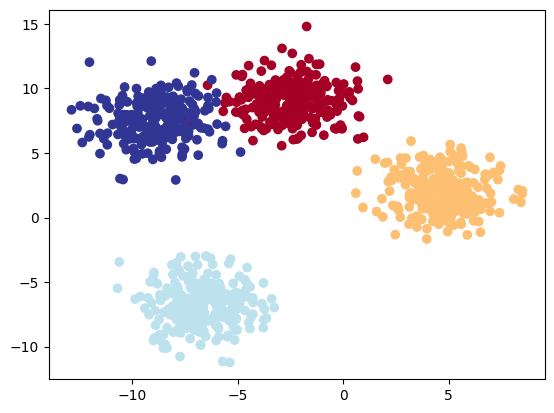

In [26]:
import matplotlib.pyplot as plt

plt.scatter(x=X_blob[:, 0],
            y=X_blob[:, 1],
            c=y_blob,
            cmap=plt.cm.RdYlBu)

In [27]:
import numpy as np
import matplotlib.pyplot as plt

""" Taken from Daniel Bourke's github:
https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py
"""

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


### Build Multi-class Classification Model

In [34]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()

        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x):
        return self.linear_layers(x)
    
model = BlobModel(input_features=2, 
                  output_features=4, 
                  hidden_units=64)
model, model.state_dict()

(BlobModel(
   (linear_layers): Sequential(
     (0): Linear(in_features=2, out_features=64, bias=True)
     (1): Linear(in_features=64, out_features=64, bias=True)
     (2): Linear(in_features=64, out_features=4, bias=True)
   )
 ),
 OrderedDict([('linear_layers.0.weight',
               tensor([[ 0.5406,  0.5869],
                       [-0.1657,  0.6496],
                       [-0.1549,  0.1427],
                       [-0.3443,  0.4153],
                       [ 0.6233, -0.5188],
                       [ 0.6146,  0.1323],
                       [ 0.5224,  0.0958],
                       [ 0.3410, -0.0998],
                       [ 0.5451,  0.1045],
                       [-0.3301,  0.1802],
                       [-0.3258, -0.0829],
                       [-0.2872,  0.4691],
                       [-0.5582, -0.3260],
                       [-0.1997, -0.4252],
                       [ 0.0667, -0.6984],
                       [ 0.6386, -0.6007],
                       [ 0.5459,  0.1

### Training model

In [35]:
model = BlobModel(input_features=2, 
                  output_features=4, 
                  hidden_units=64)

In [36]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)

# Number of epochs (loops)
epochs = 100

# Initialize empty lists to store values
epoch_count = []
loss_values = []
test_loss_values = []

# Accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [37]:
torch.manual_seed(42)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model.train()   # sets all parameters that require gradients to require gradients
    
    # 1. Forward pass
    y_logits = model(X_blob_train).squeeze()
    y_pred = torch.softmax(X_blob_train, dim=1).argmax(dim=1)   # logits -> prediction probabilities - > prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits,
                   y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    
    # 3. Zero the gradients of the optimizer
    optimizer.zero_grad()

    # 4. Perform backpropagation on the loss with respect to parameters of the model
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model(X_blob_test).squeeze()
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        # 2. Calculate loss
        test_loss = loss_fn(test_logits,
                            y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, 
                               y_pred=test_pred)
    
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.42048 | Accuracy: 3.38 | Test Loss: 0.99091 | Test Accuracy: 53.00%
Epoch: 10 | Loss: 0.23072 | Accuracy: 3.38 | Test Loss: 0.20415 | Test Accuracy: 99.00%
Epoch: 20 | Loss: 0.10450 | Accuracy: 3.38 | Test Loss: 0.09797 | Test Accuracy: 99.00%
Epoch: 30 | Loss: 0.06931 | Accuracy: 3.38 | Test Loss: 0.06155 | Test Accuracy: 99.00%
Epoch: 40 | Loss: 0.05443 | Accuracy: 3.38 | Test Loss: 0.04747 | Test Accuracy: 99.50%
Epoch: 50 | Loss: 0.04752 | Accuracy: 3.38 | Test Loss: 0.04086 | Test Accuracy: 99.50%
Epoch: 60 | Loss: 0.04316 | Accuracy: 3.38 | Test Loss: 0.03541 | Test Accuracy: 99.50%
Epoch: 70 | Loss: 0.04020 | Accuracy: 3.38 | Test Loss: 0.03250 | Test Accuracy: 99.50%
Epoch: 80 | Loss: 0.03800 | Accuracy: 3.38 | Test Loss: 0.02993 | Test Accuracy: 99.50%
Epoch: 90 | Loss: 0.03625 | Accuracy: 3.38 | Test Loss: 0.02802 | Test Accuracy: 99.50%


### Make prediction

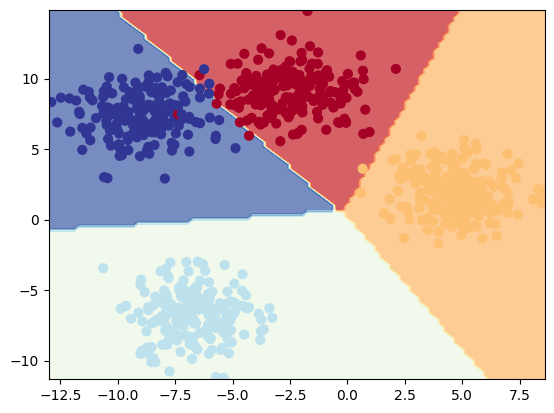

In [43]:
with torch.inference_mode():
    y_pred = torch.softmax(model(X_blob_test), dim=1)

plot_decision_boundary(model, X_blob_train, y_blob_train)